In [66]:
# Load all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import time
import random
import seaborn as sns

### Call the API, fetch the required data and create the dataframe

In [67]:
# create a data directory call Data for our data
os.makedirs("Data", exist_ok=True)
print(f"Folder Data created successfully!")

Folder Data created successfully!


In [68]:
# Declare the latitude and longitude for both cities
cities = {"Zurich": {'loc': ["47.3769", "8.5417"]},
		  "Seattle": {'loc': ["47.6062", "122.3321"]}}

In [69]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [70]:
def call_API(city, openmeteo):
    # Set the API call parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": cities[city]['loc'][0],
        "longitude": cities[city]['loc'][1],
        "start_date": "1940-01-01",
        "end_date": "2024-12-31",
        "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
                "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise",
                "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum",
                "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant",
                "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
        "timezone": cities[city].get('timezone', "Europe/Berlin"),
        "temperature_unit": "celsius",
        "wind_speed_unit": "kmh",
        "precipitation_unit": "mm"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Print the first part of the API response to validate the call data is valid
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
   
    return response

In the create_dataframe function we validate the data types as we receive the data, we also change the date format into a readable format and into a format that useful for our project as we don't need anything but the date. This save us from performing these tasks later on when we clean our data.

In [71]:
def create_dataframe(response):
	# Process data and validate variable types
	daily = response.Daily()
	daily_weather_code = daily.Variables(0).ValuesAsNumpy()
	daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
	daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
	daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
	daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
	daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
	daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
	daily_sunrise = daily.Variables(7).ValuesAsNumpy()
	daily_sunset = daily.Variables(8).ValuesAsNumpy()
	daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
	daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
	daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
	daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
	daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
	daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
	daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
	daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
	daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
	daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
	daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()
	
	# Format the date variable to readable format
	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
		).strftime('%Y/%m/%d')
	}
	
	# Create the pandas dataframe
	daily_data["weather_code"] = daily_weather_code
	daily_data["temperature_2m_max"] = daily_temperature_2m_max
	daily_data["temperature_2m_min"] = daily_temperature_2m_min
	daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
	daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
	daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
	daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
	daily_data["sunrise"] = daily_sunrise
	daily_data["sunset"] = daily_sunset
	daily_data["daylight_duration"] = daily_daylight_duration
	daily_data["sunshine_duration"] = daily_sunshine_duration
	daily_data["precipitation_sum"] = daily_precipitation_sum
	daily_data["rain_sum"] = daily_rain_sum
	daily_data["snowfall_sum"] = daily_snowfall_sum
	daily_data["precipitation_hours"] = daily_precipitation_hours
	daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
	daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
	daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
	daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
	daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
	
	# Make a dataframe from the dictionary
	daily_dataframe = pd.DataFrame(data = daily_data)
	
	return daily_dataframe

In [72]:
def save_df(data, city):
	# Save the dataframe as csv file
	data.to_csv(f"Data/{city}.csv", index = False)
	print(f"Saved data for '{city}' successfully!")

In [73]:
def combine_dataframes():
	# Create a single dataframe from the 2 datasets
	# Load the 2 datasets
	df1 = pd.read_csv("Data/Zurich.csv")
	df2 = pd.read_csv("Data/Seattle.csv")
	
	# Add a column to contains the city name
	df1['City'] = 'Zurich'
	df2['City'] = 'Seattle'
	
	# Concatenate the 2 dataframes
	start_df = pd.concat([df1, df2], ignore_index=True)
	
	# Write combined dataframes to csv file
	start_df.to_csv("Data/start.csv", index = False)

In [74]:
# Call the API and save the as csv files
# Saving as csv files to limit the amount of calls to data provider
count = 0
for city in cities:
    response = call_API(city, openmeteo)
    data = create_dataframe(response)
    save_df(data, city)
    print('\n')

    # Delay the 2nd API call for 2 minutes to not violate limits on API calls
    if count < 1:
        print("\n Taking a 2 minute break, please be patient........ ")
        time.sleep(120)
    count += 1

Coordinates 47.34621810913086°N 8.54337215423584°E
Elevation 409.0 m asl
Timezone b'Europe/Berlin' b'GMT+2'
Timezone difference to GMT+0 7200 s
Saved data for 'Zurich' successfully!



 Taking a 2 minute break, please be patient........ 
Coordinates 47.62741470336914°N 122.17462158203125°E
Elevation 577.0 m asl
Timezone b'Europe/Berlin' b'GMT+2'
Timezone difference to GMT+0 7200 s
Saved data for 'Seattle' successfully!




### Clean the dataset
Some of the data cleaning was preformed when we received the data from the API calls as it was deemed a more effiecent.

In [75]:
# Create a single dataframe from the 2 datasets
# Load the 2 datasets
df1 = pd.read_csv("Data/Zurich.csv")
df2 = pd.read_csv("Data/Seattle.csv")

# Add a column to contains the city name
df1['city'] = 'Zurich'
df2['city'] = 'Seattle'

In [76]:
# Concatenate the 2 dataframes
df = pd.concat([df1, df2], ignore_index=True)

In [77]:
# Delete files no longer required
os.remove("Data/Seattle.csv")
os.remove("Data/Zurich.csv")

In [78]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [79]:
# Check for empty or all zeros columns
empty_cols = []
for col in numerical_cols:
	if df[col].sum() == 0:
		empty_cols.append(col)
		
print(empty_cols)

['sunrise', 'sunset']


In [80]:
# Remove two columns with only zero values
df = df.drop(empty_cols, axis=1)

In [81]:
# Get index of rows with NaN values
nan_rows = df[df.isna().any(axis=1)].index.tolist()

print(nan_rows)

[0, 31047]


In [82]:
df = df.drop(index=nan_rows, axis=0)

In [83]:
# See if the column is the correct data type
set(df.weather_code.unique())

{np.float64(0.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(51.0),
 np.float64(53.0),
 np.float64(55.0),
 np.float64(61.0),
 np.float64(63.0),
 np.float64(65.0),
 np.float64(71.0),
 np.float64(73.0),
 np.float64(75.0)}

In [84]:
df['weather_code'] = df['weather_code'].astype(int)

In [85]:
# Write cleaned dataframe to csv file to limit API calls
df.to_csv("Data/clean.csv", index = False)

### Check the dataset for outliers

In [86]:
# Identify remaining numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [87]:
# Find outliers for each column
outlier_results = []

for col in num_cols:
    # Calculate quartiles
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = len(outliers)
    
    # Only inspect 
    if num_outliers > 0:
        outlier_results.append({
            'Column': col,
            'Outliers Count': num_outliers,
            'Min': df[col].min(),
            'Q1': Q1,
            'Median': df[col].median(),
            'Q3': Q3,
            'Max': df[col].max(),
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

# Create DataFrame with outlier results
outlier_df = pd.DataFrame(outlier_results)
print("\nOutlier Summary:")
print(outlier_df)


Outlier Summary:
                        Column  Outliers Count        Min         Q1  \
0           temperature_2m_max             102 -28.598500   3.000500   
1           temperature_2m_min             681 -35.448500  -4.549500   
2          temperature_2m_mean             304 -33.098495  -0.762271   
3     apparent_temperature_max              26 -35.357895  -1.080085   
4     apparent_temperature_min             149 -41.875416  -9.011585   
5    apparent_temperature_mean              50 -39.440940  -5.021727   
6            precipitation_sum            8736   0.000000   0.000000   
7                     rain_sum           10032   0.000000   0.000000   
8                 snowfall_sum            7709   0.000000   0.000000   
9          precipitation_hours            4548   0.000000   0.000000   
10          wind_speed_10m_max             916   1.440000   9.178235   
11          wind_gusts_10m_max             957   7.559999  23.039999   
12  et0_fao_evapotranspiration              57

In [88]:
# Get the variables that have the most outliers
outlier_col = list(outlier_df[outlier_df['Outliers Count'] > 1000].Column)

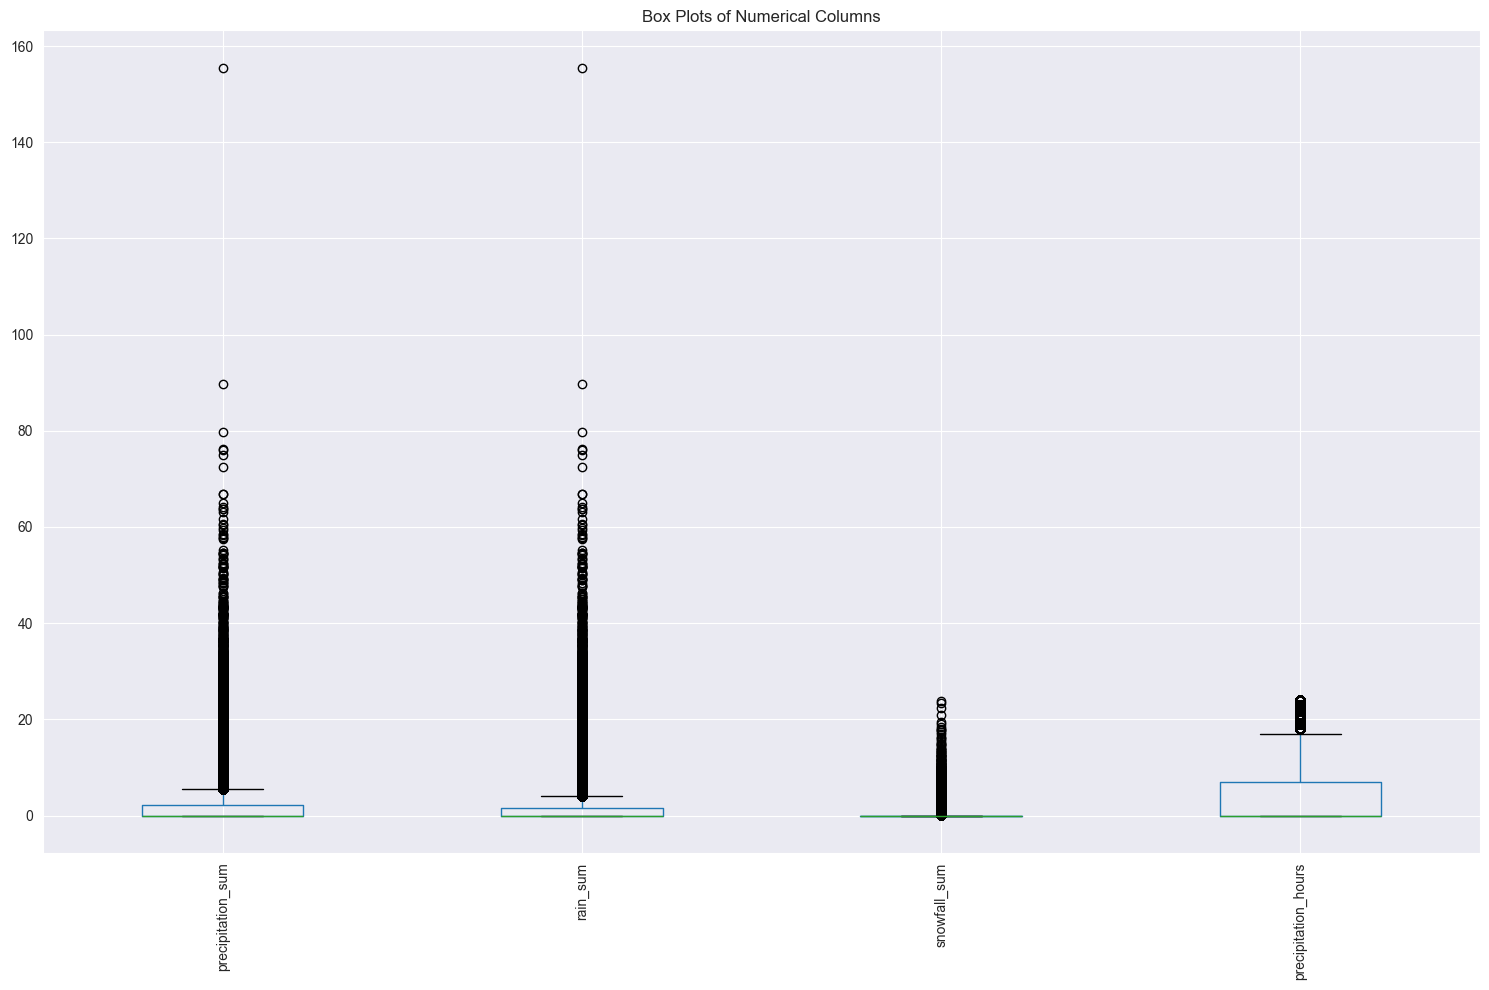

In [89]:
# Create box plots to inspect the top outliers
plt.figure(figsize=(15, 10))
df.boxplot(column=list(outlier_col), figsize=(15, 10))
plt.xticks(rotation=90)
plt.title('Box Plots of Numerical Columns')
plt.tight_layout()
plt.show()

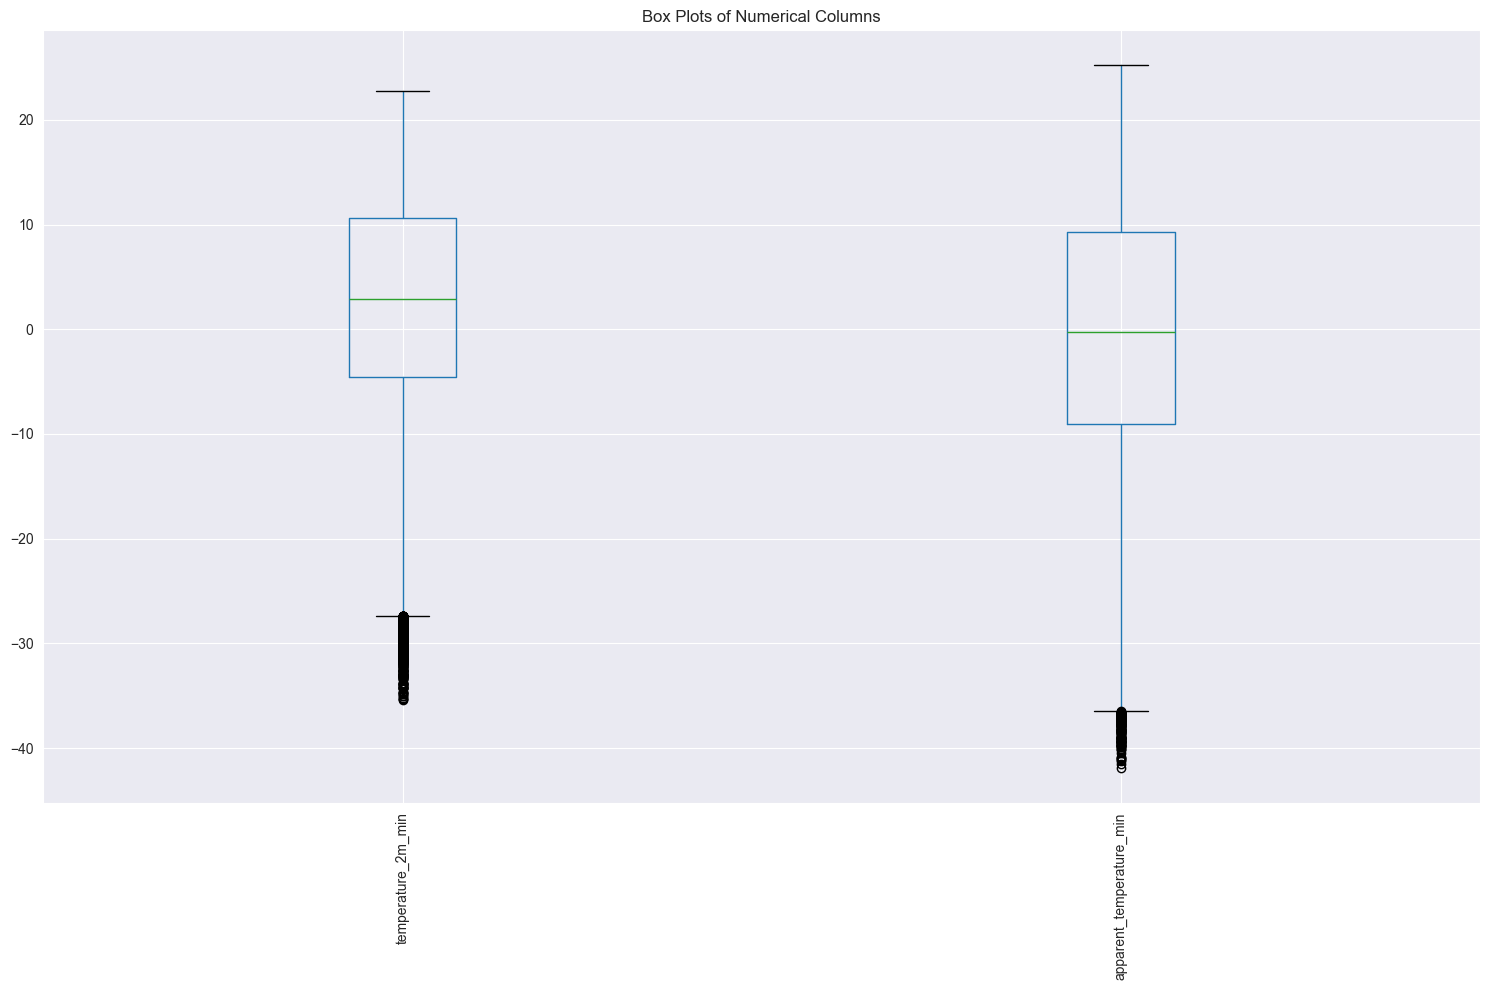

In [90]:
# Create box plots to inspect the top outliers
plt.figure(figsize=(15, 10))
df.boxplot(column=['temperature_2m_min', 'apparent_temperature_min'], figsize=(15, 10))
plt.xticks(rotation=90)
plt.title('Box Plots of Numerical Columns')
plt.tight_layout()
plt.show()

After investagting the dataset for outliers it has become clear that the dataset does have outliers, but these outliers does fall under the expected behavior for weather patterns and in most cases represents extreme weather events, while in other cases the outliers represent weather events that don't occur frequently. For example it snowing in Zurich occurs infrequently.

### Working with missing data

Because the data is to clean and has no missing data, I am going to create missing data and the demonstrate how to deal with missing data, by randomly removing data from the dataset

In [91]:
df_mis = pd.read_csv("Data/clean.csv")

In [92]:
# Generate 1000 random numbers that represents the rows to apply missing values
random_numbers = [random.randint(1, len(df_mis)) for _ in range(1000)]

In [93]:
# Get a list of all the column names
columns = list(df_mis.columns)

# Remove date and city from the list
columns.remove('date')
columns.remove('city')

In [94]:
# Randomly apply NaN values to the columns and rows
for num in random_numbers:
	for col in columns:
		if random.choice([0, 1]) == 1:
			df_mis.loc[num, col] = np.nan

In [95]:
# Check the extend of the missing data
print(df_mis.isna().sum())

date                             0
weather_code                   524
temperature_2m_max             477
temperature_2m_min             494
temperature_2m_mean            508
apparent_temperature_max       497
apparent_temperature_min       508
apparent_temperature_mean      514
daylight_duration              498
sunshine_duration              509
precipitation_sum              496
rain_sum                       480
snowfall_sum                   464
precipitation_hours            502
wind_speed_10m_max             499
wind_gusts_10m_max             499
wind_direction_10m_dominant    507
shortwave_radiation_sum        470
et0_fao_evapotranspiration     487
city                             0
dtype: int64


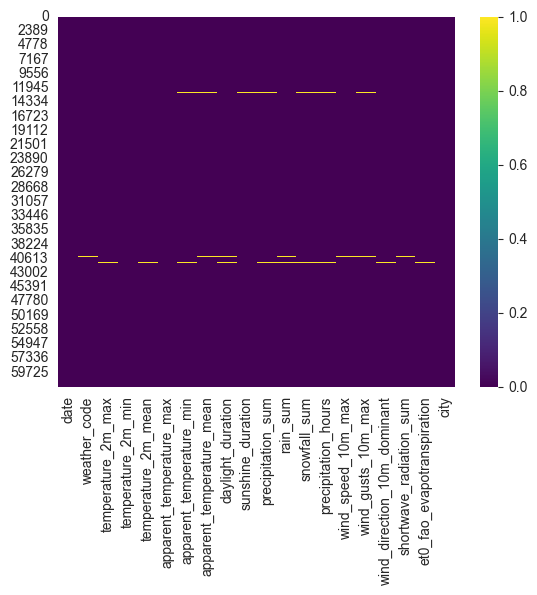

In [96]:
# Plot a heat map for missing values
sns.heatmap(df_mis.isnull(), cbar=True, cmap='viridis')
plt.show()

In [97]:
# Fill missing values with interpolation
# Using the linear method as it is the best fit for weather data
df_filled = df_mis[columns].interpolate(method='linear')

In [98]:
# Check if there is still missing values
print(df_filled.isna().sum())

weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
dtype: int64


We where able to succesfully interpolate our missing values 

### Research Question 2
##### How does Zurich and Seattle compare regarding weather seasonal attributes?
The reason Zurich and Seattle was chosen for comparisson is because they are almost placed on the same latitude, with Zurich at 47.34621810913086°N and Seattle at 47.62741470336914°N. 

In [99]:
# Create the dataframe
df = pd.read_csv("Data/clean.csv")

# Ensure datetime index
df.index = pd.DatetimeIndex(df.date)

In [100]:

# Separate Zurich and Seattle data and set the date as index
zurich_data = df[df['city'] == 'Zurich'].set_index('date')
seattle_data = df[df['city'] == 'Seattle'].set_index('date')

# Merge the dataframes on date
merged_df = zurich_data.merge(seattle_data, on='date', suffixes=('_zurich', '_seattle'))

# Drop redundant city columns
merged_df = merged_df.drop(['city_zurich', 'city_seattle'], axis=1)

# Ensure the dataframe index is of type datetime
merged_df.index = pd.DatetimeIndex(merged_df.index)

# Create a function to map months to seasons - more efficient approach
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Add season column more efficiently
merged_df['season'] = merged_df.index.month.map(get_season)

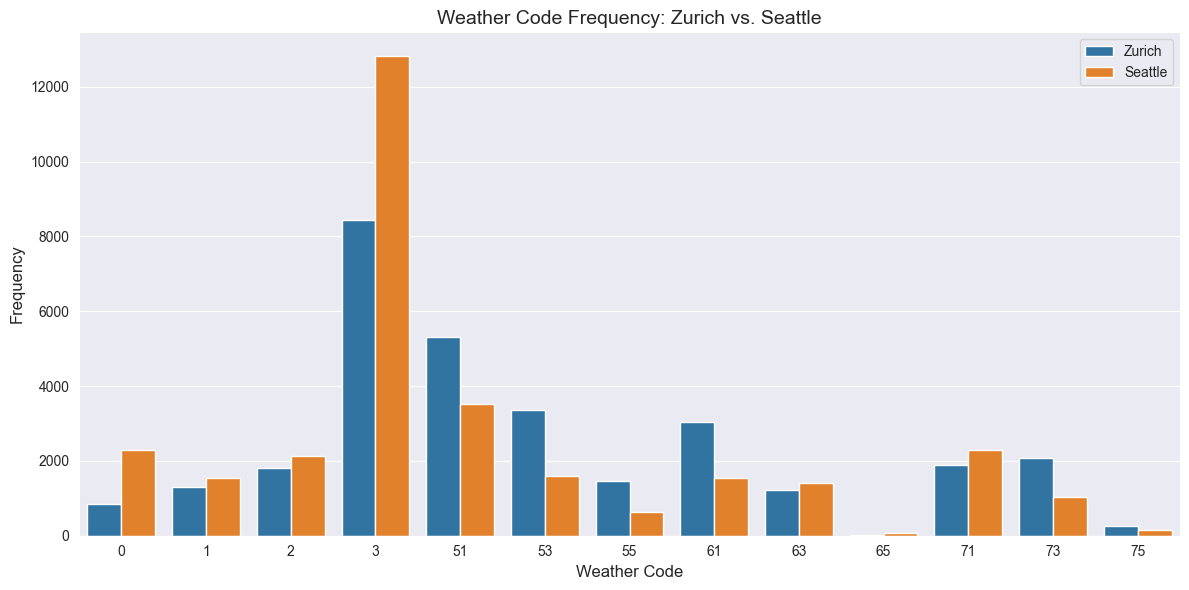

In [101]:
# Compare weather codes between cities
plt.figure(figsize=(12, 6))

# Create comparison dataframe more efficiently
zurich_counts = merged_df['weather_code_zurich'].value_counts().sort_index()
seattle_counts = merged_df['weather_code_seattle'].value_counts().sort_index()

# Combine into a single dataframe for plotting
comparison_df = pd.DataFrame({
    'Zurich': zurich_counts,
    'Seattle': seattle_counts
}).reset_index().melt(
    id_vars='index',
    value_vars=['Zurich', 'Seattle'],
    var_name='City',
    value_name='Frequency'
)

# Create a cleaner bar plot
ax = sns.barplot(x='index', y='Frequency', hue='City', data=comparison_df)

# Enhance the plot with better formatting
plt.title('Weather Code Frequency: Zurich vs. Seattle', fontsize=14)
plt.xlabel('Weather Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='')
plt.tight_layout()
plt.show()

The weather codes is called OWM codes
- 0: Cloud development not observed or not observable
- 1: Clouds generally dissolving or becoming less developed
- 2: State of sky on the whole unchanged
- 3: Clouds generally forming or developing
- 51: Drizzle, not freezing, continuous, slight at time of observation
- 53: Drizzle, not freezing, continuous, moderate at time of observation
- 55: Drizzle, not freezing, continuous, heavy at time of observation
- 61: Rain, not freezing, continuous, slight at time of observation
- 63: Rain, not freezing, continuous, moderate at time of observation
- 65: Rain, not freezing, continuous, heavy at time of observation
- 71: Continuous fall of snowflakes, slight at time of observation
- 73: Continuous fall of snowflakes, moderate at time of observation
- 75: Continuous fall of snowflakes, heavy at time of observation  
[Source](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM)

By looking at the weather codes it is clear that the most common weather state for both cities is cloudy days (Code 3) 

In [102]:

# Calculate seasonal means more efficiently
# Define the season order for consistent presentation
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Get seasonal averages, excluding weather code columns
season_stats = merged_df.drop(['weather_code_zurich', 'weather_code_seattle'], axis=1).groupby('season').mean()

# Reorder seasons for better visualization
season_stats = season_stats.reindex(season_order)

# Create a more comprehensive temperature comparison visualization
# Extract only temperature columns for cleaner analysis
temp_columns = [
    'temperature_2m_mean_zurich', 'temperature_2m_mean_seattle',
    'apparent_temperature_mean_zurich', 'apparent_temperature_mean_seattle'
]

# Create a dataframe in tidy format for seaborn plotting
temp_data = []
for column in temp_columns:
    city = 'Zurich' if 'zurich' in column else 'Seattle'
    temp_type = 'Air' if 'temperature_2m' in column else 'Apparent'
    
    for season in season_order:
        temp_value = season_stats.loc[season, column]
        temp_data.append({
            'Season': season,
            'City': city,
            'Type': temp_type,
            'Temperature': temp_value
        })

temp_df = pd.DataFrame(temp_data)

## Actual vs Apparent Temperature vs Seasonly Comparison 

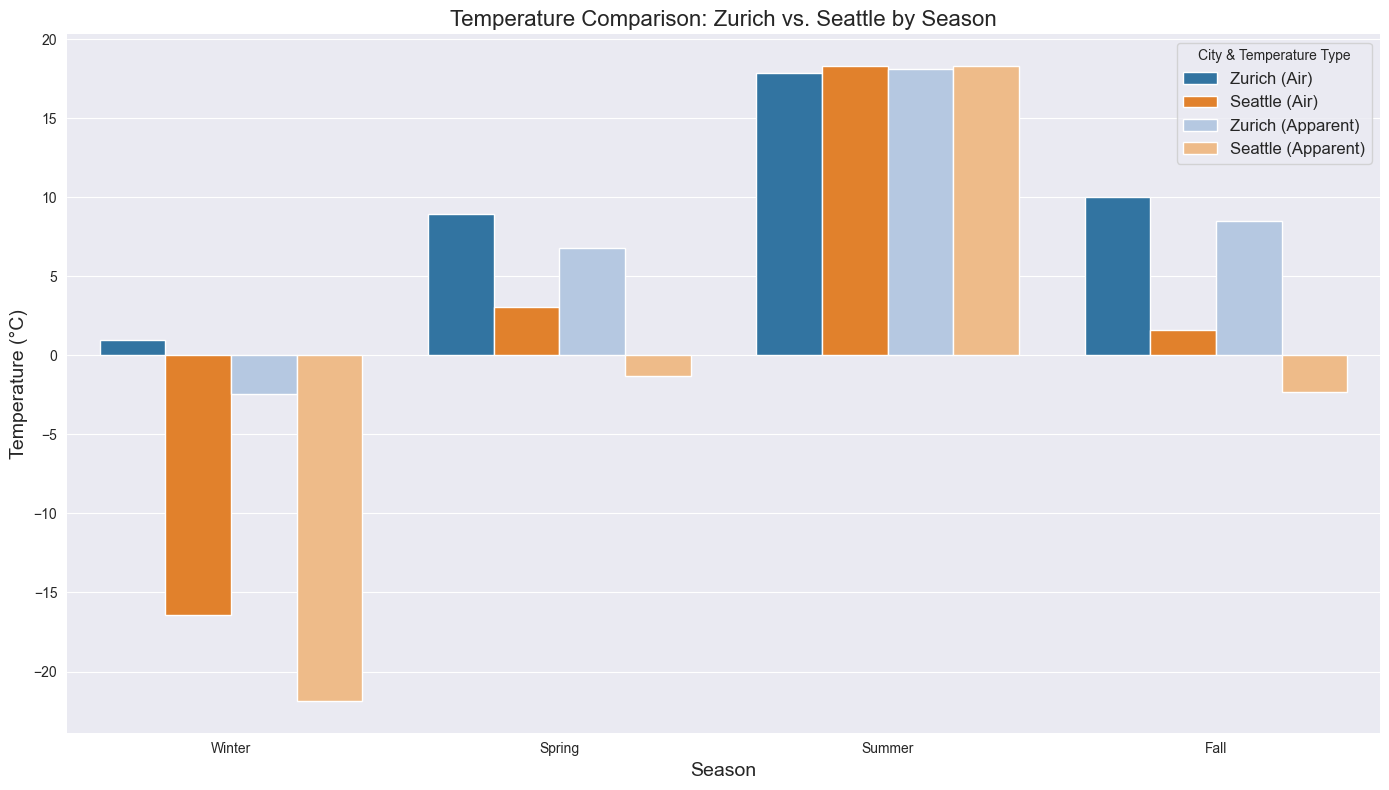

In [103]:

# Create a more informative and visually appealing temperature comparison
plt.figure(figsize=(14, 8))

# Add a column combining city and temperature type for better visualization
temp_df['City_Type'] = temp_df['City'] + ' (' + temp_df['Type'] + ')'

# Define a better color palette
custom_palette = {
    'Zurich (Air)': '#1f77b4',      # Darker blue
    'Zurich (Apparent)': '#aec7e8',  # Lighter blue
    'Seattle (Air)': '#ff7f0e',      # Darker orange
    'Seattle (Apparent)': '#ffbb78'  # Lighter orange
}

# Create an enhanced bar plot
sns.barplot(
    data=temp_df,
    x='Season',
    y='Temperature',
    hue='City_Type',
    palette=custom_palette
)

# Add plot details for better clarity
plt.title('Temperature Comparison: Zurich vs. Seattle by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.legend(title='City & Temperature Type', fontsize=12)

# Remove unnecessary chart elements
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

Apparent Temperature refers to how hot or cold the air feels to the human body, rather than the actual air temperature measured by a thermometer. It combines the effects of several environmental factors such air temperature, humitidy and wind speed.

We can see from the bar chart that Zürich and Seattle enjoy simailar temperatures during summer, with small differences between air and apparent temperatures. Seattle has milder air temperatures during spring and fall than Zürich and for both cities we can see envorimental factors having a bigger impact on apparent temperatures. While Seattle is slight colder than Zürich during the winter months it is clear that enviromental factors have a substansially larger impact on apparent temperatures than during other seasons.

## Daylight vs Sunshine Ratio

In [104]:
# Extract month from the datetime index
merged_df['month'] = merged_df.index.month

# Create month names for better readability
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
merged_df['month_name'] = merged_df['month'].map(month_names)

# Calculate sunshine ratio for both cities
merged_df['sunshine_ratio_zurich'] = merged_df['sunshine_duration_zurich'] / merged_df['daylight_duration_zurich']
merged_df['sunshine_ratio_seattle'] = merged_df['sunshine_duration_seattle'] / merged_df['daylight_duration_seattle']

# Group by month and calculate average sunshine ratio for each month
monthly_sunshine = merged_df.groupby('month_name').agg({
    'sunshine_ratio_zurich': 'mean',
    'sunshine_ratio_seattle': 'mean'
}).reset_index()

# Sort by month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sunshine['month_name'] = pd.Categorical(monthly_sunshine['month_name'], categories=month_order, ordered=True)
monthly_sunshine = monthly_sunshine.sort_values('month_name')

In [105]:
# Reshape data
sunshine_melted = pd.melt(monthly_sunshine, 
                          id_vars=['month_name'],
                          value_vars=['sunshine_ratio_zurich', 'sunshine_ratio_seattle'],
                          var_name='city', 
                          value_name='sunshine_ratio')

# Clean up city names for legend
sunshine_melted['city'] = sunshine_melted['city'].map({
    'sunshine_ratio_zurich': 'Zurich',
    'sunshine_ratio_seattle': 'Seattle'
})

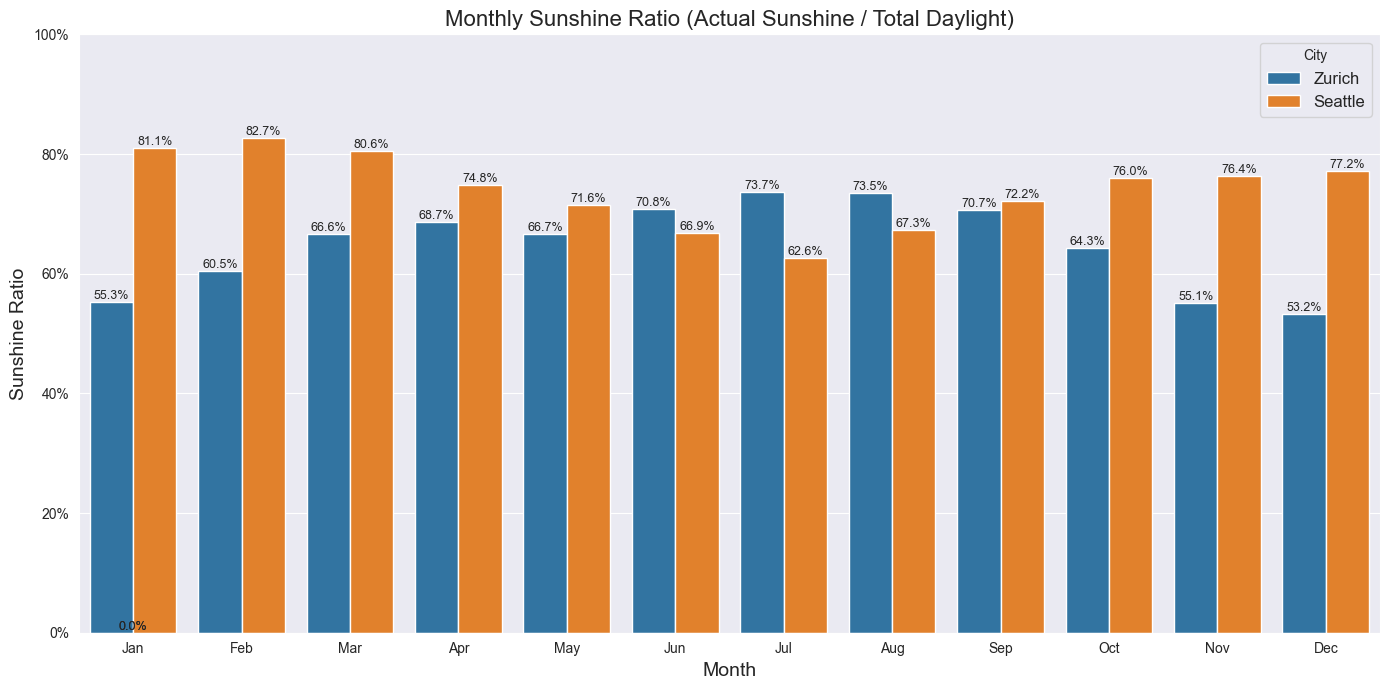

Annual average sunshine ratio for Zurich: 64.94%
Annual average sunshine ratio for Seattle: 74.05%


In [106]:
# Create bar plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='month_name', y='sunshine_ratio', hue='city', data=sunshine_melted)

# Add titles and labels
plt.title('Monthly Sunshine Ratio (Actual Sunshine / Total Daylight)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Sunshine Ratio', fontsize=14)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1 (0-100%)

# Format y-axis as percentage
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Add annotations for each bar to show the exact percentage
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.legend(title='City', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Calculate annual averages
annual_avg = merged_df.agg({
    'sunshine_ratio_zurich': 'mean',
    'sunshine_ratio_seattle': 'mean'
})

print(f"Annual average sunshine ratio for Zurich: {annual_avg['sunshine_ratio_zurich']:.2%}")
print(f"Annual average sunshine ratio for Seattle: {annual_avg['sunshine_ratio_seattle']:.2%}")